# Analysis of Handwritten Words

In this project we are going to import images of handwritten words from the [IAM Handwriting Database](http://www.fki.inf.unibe.ch/databases/iam-handwriting-database) and then use a Convolutional Neural Network to classify the image in Keras.

## Imports

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os
import datetime
%matplotlib inline


#import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model, model_from_json
from keras.layers import Dense, MaxPool2D, Conv2D, Flatten, Activation, Dropout, BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import keras.backend as K

from keras.preprocessing.image import ImageDataGenerator

In [7]:
import sys
from tensorflow.python.client import device_lib

print("Python version {}".format(sys.version))
print("Devices\n {}".format(device_lib.list_local_devices()))

Python version 3.5.6 |Anaconda, Inc.| (default, Aug 26 2018, 16:05:27) [MSC v.1900 64 bit (AMD64)]
Devices
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5724042019303336843
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3176700313
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8254716923188359824
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## Get a vocabulary to train on

In [34]:
sentence = "This is my sentence for training my model"
vocab = list(set(sentence.split(" ")))
vocab

['training', 'is', 'sentence', 'for', 'model', 'This', 'my']

## Get mapping of the image to the word
Actual word associated with the image from the words.txt file downloaded from the IAM database.  I need to find the names of the files that are associated with words in my vocabulary

In [9]:
vocabImages = {}

with open("./words.txt") as f:
    lines = f.read().split("\n")
    
    #first 18 lines are description
    for line in lines[18:-1]:
        elements = line.split(" ")
        filename = str(elements[0]) + ".png"
        word = elements[-1]
        
        if word in vocab:
            vocabImages[filename] = word

In [29]:
vocabImages

{'g06-011o-09-01.png': 'my',
 'e07-007-01-00.png': 'is',
 'g06-026e-01-01.png': 'is',
 'g07-084-01-10.png': 'is',
 'l04-153-06-09.png': 'is',
 'g06-011i-06-08.png': 'is',
 'd01-056-00-04.png': 'for',
 'e04-132-03-03.png': 'for',
 'r03-084-02-08.png': 'for',
 'a06-124-04-06.png': 'is',
 'b01-113-03-07.png': 'is',
 'c03-016d-04-04.png': 'is',
 'a02-012-00-02.png': 'is',
 'g06-011k-07-09.png': 'is',
 'd06-091-04-05.png': 'for',
 'g06-042j-00-01.png': 'is',
 'g06-011c-08-06.png': 'my',
 'c03-081e-02-00.png': 'for',
 'f02-030-06-05.png': 'for',
 'f01-139-00-01.png': 'is',
 'e02-021-07-11.png': 'is',
 'a03-089-00-01.png': 'is',
 'j04-012-06-05.png': 'is',
 'b01-062-06-07.png': 'is',
 'd07-100-03-06.png': 'is',
 'n04-218-00-00.png': 'This',
 'b04-040-00-01.png': 'is',
 'h07-075-02-04.png': 'is',
 'c06-011-04-02.png': 'is',
 'c04-023-02-07.png': 'is',
 'a01-068u-05-01.png': 'for',
 'c02-049-09-05.png': 'for',
 'b01-057-07-01.png': 'for',
 'p06-030-03-02.png': 'my',
 'e06-030-03-04.png': 'for',

In [36]:
words = {}

with open("./words.txt") as f:
    lines = f.read().split("\n")
    
    #first 18 lines are description
    for line in lines[18:-1]:
        elements = line.split(" ")
        filename = str(elements[0]) + ".png"
        word = elements[-1]
        
        if word in vocab:
            words[word] = words[word].append(filename)

KeyError: 'is'

In [33]:
words

{}

After finding the file words associaed with the vocab, I want the path and the word

In [10]:
# dictionary of filename : [path, word]
images = {}

for root,dirs,files in os.walk("data"):
    if not dirs:
        for file in files:
            if file in list(vocabImages.keys()):
                images[file] = [root , vocabImages[file]]

In [ ]:
# dictionary of word : [path, name]
words = {}

for root,dirs,files in os.walk("data"):
    if not dirs:
        for file in files:
            if file in list(vocabImages.keys()):
                word[vocabImages[file]] = [root , [file]]

## Display random image from set

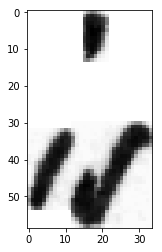

In [11]:
rand = 42

randomImage = list(images)[rand]
filename = os.path.join(images[randomImage][0], randomImage)

img = mpimg.imread(filename)
plt.imshow(img, cmap="gray")

In [12]:
#check we've got the right word for this image
myword = images[randomImage][1]
myword

'is'

## Characteristics of image

In order to build the classifier there are various attributes associated with the image that we will need to know:  
* the actual word of the image, which we will then map to a categorical variable
* the size of the image, so words are longer than others so will take up more space.  However, our NN will take a specific dimension as its inputs therefore we will need to resize each image to this maximum size.  I will not stretch and distort the image using PILLOW, but add no-information padding around the original image to build up its size

In [13]:
# Here we have the dictiionary of images we created with its full (filename) name, its path and the true word 
# associated with the image 
list(images.items())[rand]

('e06-046-04-05.png', ['data\\e06\\e06-046', 'is'])

In [14]:
# Here we have the image converted to a numpy array - something Keras can read and the dimension of the image
data = np.asarray( img, dtype="float32" )

print("The image has dimensions: {}".format(data.shape))
print("The image as a numpy array:\n {}".format(data[:5,:5]))

The image has dimensions: (59, 34)
The image as a numpy array:
 [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]


Next we need to convert all the words into a single list - so we know how unique many words we have and their position in the list - which we will use to identify the word when its a categorical variable

In [26]:
wordlist = [ w[1][1] for w in list(images.items())  ]

In [28]:
print("My random word '{}' chosen above is at postion {} in the wordlist"\
      .format(wordlist[wordlist.index(myword)], wordlist.index(myword)))

My random word 'is' chosen above is at postion 1 in the wordlist


## Resize all images to same size

In [19]:
for word in wordlist[0]:
    filename = os.path.join(images[word][0], word)
    img = Image.open(filename)

KeyError: 't'

In [23]:
w = wordlist[0]
images

{'g06-011o-09-01.png': ['data\\g06\\g06-011o', 'my'],
 'e07-007-01-00.png': ['data\\e07\\e07-007', 'is'],
 'g06-026e-01-01.png': ['data\\g06\\g06-026e', 'is'],
 'g07-084-01-10.png': ['data\\g07\\g07-084', 'is'],
 'l04-153-06-09.png': ['data\\l04\\l04-153', 'is'],
 'g06-011i-06-08.png': ['data\\g06\\g06-011i', 'is'],
 'd01-056-00-04.png': ['data\\d01\\d01-056', 'for'],
 'e04-132-03-03.png': ['data\\e04\\e04-132', 'for'],
 'r03-084-02-08.png': ['data\\r03\\r03-084', 'for'],
 'a06-124-04-06.png': ['data\\a06\\a06-124', 'is'],
 'b01-113-03-07.png': ['data\\b01\\b01-113', 'is'],
 'c03-016d-04-04.png': ['data\\c03\\c03-016d', 'is'],
 'a02-012-00-02.png': ['data\\a02\\a02-012', 'is'],
 'g06-011k-07-09.png': ['data\\g06\\g06-011k', 'is'],
 'd06-091-04-05.png': ['data\\d06\\d06-091', 'for'],
 'g06-042j-00-01.png': ['data\\g06\\g06-042j', 'is'],
 'g06-011c-08-06.png': ['data\\g06\\g06-011c', 'my'],
 'c03-081e-02-00.png': ['data\\c03\\c03-081e', 'for'],
 'f02-030-06-05.png': ['data\\f02\\f02-030'

In [16]:
objs = list()

for word in myWords:
    filename = os.path.join(images[word][0], word)
    img = mpimg.imread(filename)
    
    objs.append(Words(name = images[word],  
                       path = images[word][0], 
                       word = images[word][1], 
                       wordIndex = wordlist.index(images[word][1]),
                       size = img.shape, 
                       data = np.asarray( img, dtype="float32" )
                      )
               )
    


In [17]:
X = objs[0].data
X = X[np.newaxis, ...]

y = []
y.append(objs[0].wordIndex)

for obj in objs[1:]:
    X_temp = obj.data[np.newaxis, ...]
    X = np.concatenate((X, X_temp), axis=0)
    y.append(obj.wordIndex)
y = np.asarray(y)

#Create tensor
X = X.reshape(-1, X.shape[1], X.shape[2], 1)
#shape is num_Obs, height, width, colour channels
X.shape

(2076, 206, 302, 1)

In [18]:
#Save arrays
np.save("./numpyArrays/X", X)
np.save("./numpyArrays/y", y)

In [2]:
#Load arrays
X = np.load("./numpyArrays/X.npy")
y = np.load("./numpyArrays/y.npy")

In [3]:
# Train test split
from sklearn.model_selection import train_test_split

y_cat = to_categorical(y, y.shape[0])
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.33, random_state=42)

## Modelling

In [4]:
def create_model(filters=32, window_size=(12,12), pool_size=(4,4), neurons=512,
                 batch_size=32, epochs=5, dropout=0.0):
    
    K.clear_session()

    model = Sequential()
    
    #Convolutional layers
    model.add(Conv2D(filters, window_size, activation='relu', padding='same', 
                     input_shape = (X_train.shape[1], X_train.shape[2], 1)) )
    model.add(Conv2D(filters, window_size, activation='relu'))
    model.add(MaxPool2D(pool_size=pool_size))
    model.add(Activation('relu'))
    
    model.add(Conv2D(filters * 2, window_size, activation='relu', padding='same'))
    model.add(Conv2D(filters * 2, window_size, activation='relu'))
    model.add(MaxPool2D(pool_size=pool_size))
    model.add(Activation('relu'))

    #Dense layers
    model.add(Flatten())
    model.add(Dropout(dropout)) 
    model.add(Dense(neurons, activation='relu'))
    model.add(BatchNormalization())
        
    #Output
    model.add(Dense(y_cat.shape[1], activation='softmax'))
    return model


def train(model):
    #setup model
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    #set callbacks
    now = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
    tensorboard = TensorBoard(log_dir="logs/{}".format(now))
    
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, 
                                  mode='auto')
    
    checkpointer = ModelCheckpoint(filepath="./checkpoint/weights.hdf5", verbose=1, save_best_only=True)
    
    datagen = ImageDataGenerator(rotation_range=30)
    
    #train
    h = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                            validation_data=(X_test,y_test),
                            epochs=epochs, steps_per_epoch=len(X_train) // batch_size,
                            verbose=0, shuffle=True)
    return h

### Initial test

In [ ]:
filters=32
window_size=(12,12) 
pool_size=(4,4) 
neurons=512
batch_size=32
epochs=2
dropout=0.4

In [ ]:
#Train the model
model =  create_model(filters=filters, window_size=window_size, pool_size=pool_size, 
                      neurons=neurons, batch_size=batch_size, epochs=epochs, dropout=dropout)

#setup model
history = train(model)

#Evaluation model
test_accuracy = model.evaluate(X_test, y_test)[1]
test_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
print("Model accuracy {}%".format(np.round(test_accuracy*100,2)))

#Save model
model.save("InitialModel.h5")

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.xlabel('Epochs')

In [5]:
filters = [8, 16, 32, 64, 128]
window_sizes =[(4,4), (8,8), (12,12), (16,16), (32,32)] 
pool_sizes = [(4,4), (8,8), (16,16)] 
num_neurons = [128, 512, 1024]
batch_sizes = [8, 16, 32]
num_epochs = [20, 50, 100, 200, 250]
dropout = 0

0. Model test accuracy 97.96% with: filters 8, window_size (8, 8),
            pool_size (8, 8), neurons 1024, batch_size 139,
            epochs 100 and dropout 0.4
            
1. Model test accuracy 98.98% with: filters 16, window_size (8, 8),
            pool_size (8, 8), neurons 128, batch_size 139,
            epochs 100 and dropout 0.4
            


ResourceExhaustedError: OOM when allocating tensor with shape[139,32,199,295] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d_2/convolution = Conv2D[T=DT_FLOAT, _class=["loc:@training/RMSprop/gradients/conv2d_2/convolution_grad/Conv2DBackpropFilter"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_1/Relu, conv2d_2/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: loss/mul/_143 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1130_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


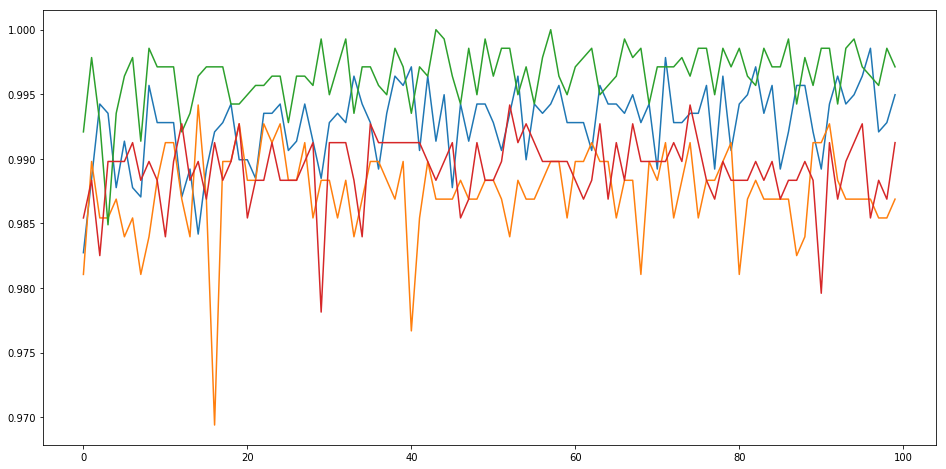

In [21]:
plt.rcParams["figure.figsize"] = (16,8)

size = 3

for i in range(size):
    f = filters[i]
    window_size = window_sizes[1]#window_sizes[np.random.choice(len(window_sizes))]
    pool_size = pool_sizes[1]#pool_sizes[np.random.choice(len(pool_sizes))]
    neurons = num_neurons[np.random.choice(len(num_neurons))]
    batch_size = int(len(X_train)/10)
    epochs = 100
    dropout = 0.4

    #Train the model
    model =  create_model(filters=f, window_size=window_size, pool_size=pool_size, 
                          neurons=neurons, batch_size=batch_size, 
                          epochs=epochs, dropout=dropout)

    m = train(model)

    #Evaluation model
    test_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]

    if i == 0:
        best_model = model
        best_accuracy = test_accuracy
    elif test_accuracy < best_accuracy:
        best_model = model
        best_accuracy = test_accuracy

    msg = """{counter}. Model test accuracy {acc}% with: filters {filters}, window_size {window_size},
            pool_size {pool_size}, neurons {neurons}, batch_size {batch_size},
            epochs {epochs} and dropout {dropout}
            """.format(counter=i, acc=np.round(test_accuracy*100,2),
                        filters=f, window_size=window_size, pool_size=pool_size,
                        neurons=neurons, batch_size=batch_size, 
                        epochs=epochs, dropout=dropout)

    print(msg)
    
    plt.plot(train(model).history['acc'], label="Training {}".format(i))
    plt.plot(train(model).history['val_acc'], label="Validation {}".format(i))

plt.legend(loc="best")
plt.title("Accuracy")
plt.xlabel('Epochs')
plt.show()    
    
    
best_model.save("BestModel.h5")

### Assess the model

In [ ]:
model = load_model('./model.h5')
# make predictions
yhat = model.predict(X_test, verbose=0)
print(yhat)

In [ ]:
predictions = [np.argmax(obs) for obs in yhat]

In [ ]:
index = 4 

print("The predicted word is: '{}'".format(wordlist[index]))8,8

t = X_train[index]
t = t.reshape((t.shape[0], t.shape[1]))
plt.imshow(t, cmap="gray")